# Cat Breed Classifier

This project is to train image classifier model to classify Cat Breeds dataset images. It has frontend as web application showing Quiz which allow user to take on guessing cat breed on the images.


![Quiz Image](Report/quiz.png)

Then after user pick answer, it will show result comparing user's with ChatGPT-4o-mini (OpenRouter API key required) and 4 Deep Learning Models. The rationale of LLM and GradCAM has been implemented to show model interpretability.

![Answer Image](Report/evaluation.png)

## Data Sets
- Dataset is from Kaggle from 'Geno Cat Breed Image Collection' dataset (url: https://www.kaggle.com/datasets/shawngano/gano-cat-breed-image-collection)
- Contains 15 cat breeds with 375 photos for each breed (total 5,625 photos)
- Preprocessing step
  - Resize to 256x256
  - Random Crop to 224x224
  - Random Horizontal Flip
  - Random Rotation
  - Convert to Tensor
  - Normalize with mean and std of ImageNet

In [1]:
import os 
import shutil
import kagglehub
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision import transforms
import torch

def get_transformation() -> transforms.Compose:
    return transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.RandomCrop((224, 224)),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(10),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])]
    )

path = kagglehub.dataset_download("shawngano/gano-cat-breed-image-collection") 

# Copy data to local folder using a relative path
local_path = "./data"

# Check if directory exists before removing it
if os.path.exists(local_path):
    shutil.rmtree(local_path)

# Copy the data (this will create the directory)
shutil.copytree(path, local_path)  
path = local_path 

transform = get_transformation()

dataset = ImageFolder(root=os.path.join(path, "Gano-Cat-Breeds-V1_1"), transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=8)

device = torch.device("mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

## Model Architecture

### Custom Model (1 Model)
1. CNN Model
  - 5 Convolutional Layers 
  - 2 Fully Connected Layers
  - 1 Dropout Layer in between the two FC Layers

from src/model_train.py


In [2]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms

class CatBreedClassifier(nn.Module):
    def __init__(self):
        super(CatBreedClassifier, self).__init__()
        self.conv_block = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64 x 112 x 112
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 128 x 56 x 56
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 256 x 28 x 28
            torch.nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 512 x 14 x 14
            torch.nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),  # Changed from 1024 to 512
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)   # Output: 1024 x 7 x 7
        )
        
        # Calculate the flattened size: 512 channels * 7 * 7 = 25088
        self.fc_block = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(1024 * 7 * 7, 512),  # Adjusted input size
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 15),  # 15 breeds
        )
        
        
    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x

### Transfer Learning (3 models)
2. VGG 16 Model 

In [3]:
def get_vgg_model() -> nn.Module:
    vgg_model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)
    for param in vgg_model.parameters():
        param.requires_grad = False
    vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, 15)
    return vgg_model

3. ResNet 18 Model 

In [4]:
def get_resnet_model() -> nn.Module:
    res_model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
    for param in res_model.parameters():
        param.requires_grad = False
    res_model.fc = nn.Linear(res_model.fc.in_features, 15)
    return res_model

4. EfficientNet B2 Model 

In [5]:
def get_efficient_net_model() -> nn.Module:
    eff_model =  torchvision.models.efficientnet_b2(weights=torchvision.models.EfficientNet_B2_Weights.IMAGENET1K_V1)
    for param in eff_model.parameters():
        param.requires_grad = False
    eff_model.classifier[1] = nn.Linear(eff_model.classifier[1].in_features, 15)
    return eff_model

## Training
All 4 models has been trained using same hyperparamters for comparison.


- Training Batch Size: 128
- Epochs: 20 for CNN model and 10 for transfer learning models.
- Loss Function: Cross Entropy Loss
- Optimizer: SGD
    - Learning Rate: 0.01 for CNN model and 0.001 for transfer learning models.
    - Momentum: 0.9


After finish training model saved to .pth for later used for inference result on Cat Quiz program.


![pth_file](Report/pth.png)

- train_model = function to train model and saved training accuracy/loss and validation accuracy/loss for later display.

In [6]:
def train_model(app_state,model: nn.Module, model_name: str) -> tuple[list[float], list[float], list[float], list[float], float]:
    print(f"Training model on {app_state.device}")
    transform = get_transformation()
     
    print(f"Loading dataset")
    dataset = ImageFolder(app_state.image_path, transform=transform) 
    
    # Split dataset into train and test sets (80% train, 20% test)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    # Create data loaders for both sets
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
    
    print(f"Dataset split: {train_size} training samples, {test_size} test samples")
    
    print(f"Loading model")
    model.to(app_state.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []
    
    start_time = time.time()
    for epoch in range(5):
        model.train()
        
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs = inputs.to(app_state.device)
            labels = labels.to(app_state.device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item()}")
            
        training_loss.append(running_loss / len(train_loader))
        training_accuracy.append(correct / total)
            
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            correct = 0
            total = 0
            for i, data in enumerate(test_loader, 0):
                inputs, labels = data
                inputs = inputs.to(app_state.device)
                labels = labels.to(app_state.device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0) 
                correct += (predicted == labels).sum().item()
            
            validation_loss.append(running_loss / len(test_loader))
            validation_accuracy.append(correct / total)
            
        print(f"Accuracy of the network on the {total} test images: {100 * correct / total}%")
    print(f"Finished Training")
    print(f"Loss: {running_loss / len(train_loader)}")
    training_time = time.time() - start_time
    print(f"Saving model to {model_name}")
    scripted_model = torch.jit.script(model)
    torch.jit.save(scripted_model, model_name)
    
    return training_loss, training_accuracy, validation_loss, validation_accuracy, training_time

## Result and Evaluation

### Training Accuracy/Loss
- While models were trained directly in application, both training and validation accuracy/loss will be kepted for visualization in web application later. Below chart shows training and validation accuracy/loss for each model that captured directly from web application.

![eval1](Report/eval1.png)

![eval2](Report/eval2.png)

![eval3](Report/eval3.png)

- Chart below shows time used for training each model, custom CNN train for 20 epochs, while others model trained for 10 epochs.

![eval4](Report/eval4.png)

### Testing Accuracy/Loss

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def predict_and_evaluate(model):
    # For collecting all targets and predictions
    all_preds = []
    all_labels = []
    
    model.eval()
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    plt.figure(figsize=(10, 7))
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot()
    
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

#### CNN Model

<Figure size 1000x700 with 0 Axes>

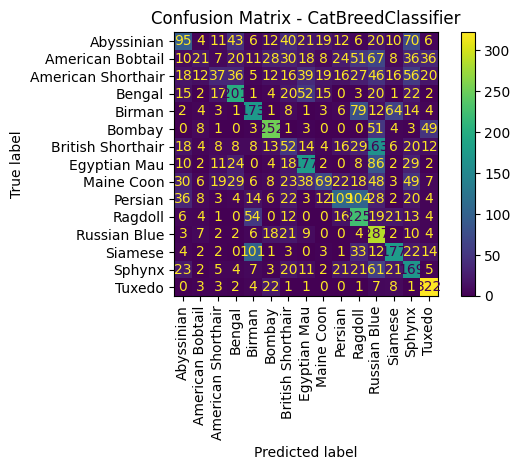

                    precision    recall  f1-score   support

        Abyssinian       0.35      0.25      0.29       375
  American Bobtail       0.24      0.06      0.09       375
American Shorthair       0.28      0.10      0.15       375
            Bengal       0.54      0.54      0.54       375
            Birman       0.43      0.46      0.45       375
            Bombay       0.66      0.67      0.66       375
 British Shorthair       0.18      0.14      0.16       375
      Egyptian Mau       0.46      0.47      0.46       375
        Maine Coon       0.44      0.18      0.26       375
           Persian       0.45      0.29      0.35       375
           Ragdoll       0.37      0.60      0.46       375
      Russian Blue       0.31      0.77      0.44       375
           Siamese       0.51      0.47      0.49       375
            Sphynx       0.32      0.45      0.37       375
            Tuxedo       0.66      0.86      0.74       375

          accuracy                    

In [8]:
cnn_model = CatBreedClassifier().to(device)
cnn_model.load_state_dict(torch.jit.load('classification_model.pth').state_dict()) 

predict_and_evaluate(cnn_model)

#### EfficientNet B2 Model

<Figure size 1000x700 with 0 Axes>

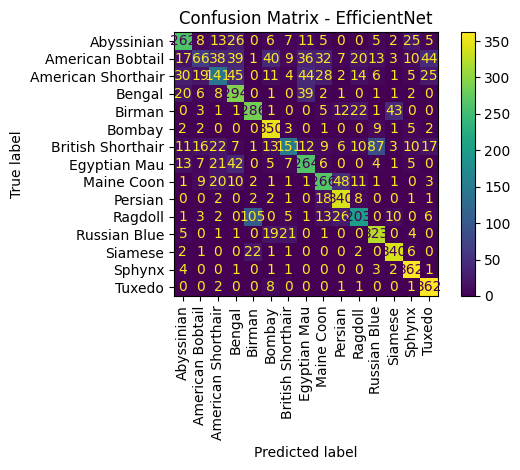

                    precision    recall  f1-score   support

        Abyssinian       0.71      0.70      0.71       375
  American Bobtail       0.47      0.18      0.26       375
American Shorthair       0.52      0.38      0.44       375
            Bengal       0.63      0.78      0.70       375
            Birman       0.68      0.76      0.72       375
            Bombay       0.76      0.93      0.84       375
 British Shorthair       0.72      0.40      0.52       375
      Egyptian Mau       0.65      0.70      0.67       375
        Maine Coon       0.69      0.71      0.70       375
           Persian       0.77      0.91      0.83       375
           Ragdoll       0.70      0.54      0.61       375
      Russian Blue       0.71      0.86      0.78       375
           Siamese       0.83      0.91      0.87       375
            Sphynx       0.83      0.97      0.89       375
            Tuxedo       0.78      0.97      0.86       375

          accuracy                    

In [9]:
eff_model = get_efficient_net_model().to(device)
eff_model.load_state_dict(torch.jit.load('efficientnet_model.pth').state_dict())

predict_and_evaluate(eff_model)

### ResNet18 Model

<Figure size 1000x700 with 0 Axes>

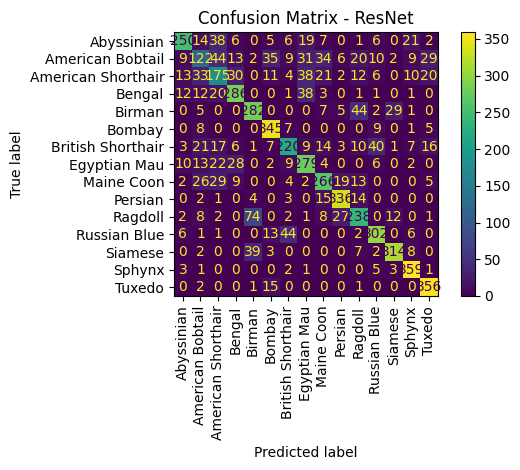

                    precision    recall  f1-score   support

        Abyssinian       0.81      0.67      0.73       375
  American Bobtail       0.45      0.33      0.38       375
American Shorthair       0.50      0.47      0.48       375
            Bengal       0.76      0.76      0.76       375
            Birman       0.70      0.75      0.72       375
            Bombay       0.79      0.92      0.85       375
 British Shorthair       0.71      0.59      0.64       375
      Egyptian Mau       0.67      0.74      0.70       375
        Maine Coon       0.70      0.71      0.71       375
           Persian       0.84      0.90      0.87       375
           Ragdoll       0.66      0.63      0.64       375
      Russian Blue       0.78      0.81      0.79       375
           Siamese       0.87      0.84      0.85       375
            Sphynx       0.84      0.96      0.90       375
            Tuxedo       0.82      0.95      0.88       375

          accuracy                    

In [10]:
res_model = get_resnet_model().to(device)
res_model.load_state_dict(torch.jit.load('resnet_model.pth').state_dict())

predict_and_evaluate(res_model)

### VGG Model

<Figure size 1000x700 with 0 Axes>

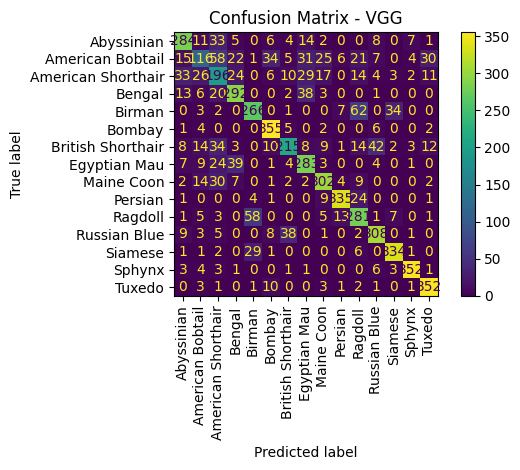

                    precision    recall  f1-score   support

        Abyssinian       0.75      0.76      0.75       375
  American Bobtail       0.53      0.31      0.39       375
American Shorthair       0.48      0.52      0.50       375
            Bengal       0.74      0.78      0.76       375
            Birman       0.74      0.71      0.72       375
            Bombay       0.82      0.95      0.88       375
 British Shorthair       0.75      0.57      0.65       375
      Egyptian Mau       0.70      0.75      0.72       375
        Maine Coon       0.79      0.81      0.80       375
           Persian       0.91      0.89      0.90       375
           Ragdoll       0.65      0.75      0.69       375
      Russian Blue       0.79      0.82      0.81       375
           Siamese       0.87      0.89      0.88       375
            Sphynx       0.95      0.94      0.94       375
            Tuxedo       0.85      0.94      0.89       375

          accuracy                    

In [11]:
vgg_model = get_vgg_model().to(device)
vgg_model.load_state_dict(torch.jit.load('vgg_model.pth').state_dict())

predict_and_evaluate(vgg_model)

## Visualization and Interpretability 

- GradCAM has been implemented for each models.
  - Color will gradient from Blue(0%) -> Cyan(25%) -> Green(50%) -> Yellow(75%) -> Red(100%) impact to features that CNN layer consider.

- Code below show GradCAM implemmented on CNN Layer selection for each model from src\\model_train.py

```py
    target_layer = None
    
    if model_name == Models.ClassificationModel:
        # For custom CNN, use the last conv layer in conv_block
        target_layer = original_model.conv_block[-3]  # Get the last Conv2d before the final MaxPool
    elif model_name == Models.ResNetModel:
        # For ResNet, use the last layer in layer4
        target_layer = original_model.layer4[-1].conv2
    elif model_name == Models.EfficientNetModel:
        # For EfficientNet, use the last conv layer in features 
        target_layer = original_model.features[-1][0] 
    elif model_name == Models.VGGModel:
        # For VGG, use the last conv layer in features
        for module in original_model.features:
            if isinstance(module, nn.Conv2d):
                target_layer = module
                
```

Below image show GradCAM implemented in web application showing each model's area of interest on a cat image.

![gradcam](Report/gradcam.png)

## Conclusion

- In this project, we have created a web application using NiceGUI framework. This application uses PyTorch to train and evaluate models for different cat breeds. Custom CNN, ResNet18, EfficientNet B2, and VGG16 models.
- GradCAM has been implemented for each models to visualize the feature importance of the models.

| Model          | Parameters | Accuracy | Loss | Training Time (seconds) |
|---------------|----:|----------:|-------:|-------------------------:|
| Custom CNN Model | 31.9 Millions  | 42% | 1.86 | 2,698                  |
| EfficientNet Model | 9.1 Millions | 71% | 1.40 | 1,256                |
| ResNet Model      | 11.7 Millions | 73% | 0.99 | 2,357                  |
| VGG Model       | 138.3 Millions | 76% | 0.81 | 1,314                 | 

- VGG16 Model is the best model bases on confusion matrix and accuracy score, but it contains very large number of parameters (138 Million parameters).
- ResNet18 Model on the other hand, has smaller number of parameters (11.7 Million parameters) and nearly the same performance as VGG16.
- EfficientNet B2 has 9.1 Million parameters and slightly lower accuracy compared to VGG16 and ResNet18 on this dataset.
- ChatGTP-4o-mini which is multi-model has image recognition capabilities. It can be used for cat image classification and provide rationale for its predictions.
